# Load Modules

In [1]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report

import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from os.path import exists

Using TensorFlow backend.


# Directory Structure

In [2]:
# Create a new directory
base_dir = '.\\Documents\\Datasets\\base_dir'

if not exists(base_dir):
    os.mkdir(base_dir)

    # now we create 7 folders inside 'base_dir':
    # train_dir
        # nv
        # mel
        # bkl
        # bcc
        # akiec
        # vasc
        # df
    
    # val_dir
        # nv
        # mel
        # bkl
        # bcc
        # akiec
        # vasc
        # df

    # create a path to 'base_dir' to which we will join the names of the new folders
    # train_dir
    train_dir = os.path.join(base_dir, 'train_dir')
    os.mkdir(train_dir)

    # create new folders inside train_dir
    nv = os.path.join(train_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(train_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(train_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(train_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(train_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(train_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(train_dir, 'df')
    os.mkdir(df)

    # val_dir
    val_dir = os.path.join(base_dir, 'val_dir')
    os.mkdir(val_dir)

    # create new folders inside val_dir
    nv = os.path.join(val_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(val_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(val_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(val_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(val_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(val_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(val_dir, 'df')
    os.mkdir(df)
  
   # val_dir
    test_dir = os.path.join(base_dir, 'test_dir')
    os.mkdir(test_dir)
   # create new folders inside val_dir
    nv = os.path.join(test_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(test_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(test_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(test_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(test_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(test_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(test_dir, 'df')
    os.mkdir(df)

# Load MetaData

In [3]:
df_data = pd.read_csv('.\\Documents\\Datasets\\HAM10000_metadata')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [4]:
df_data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0000835,ISIC_0032968,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


# Exploratory Data Analysis (EDA)

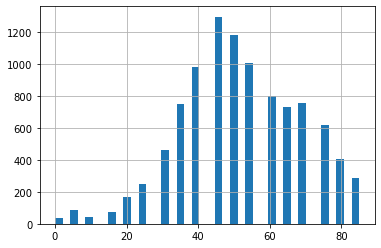

In [5]:
df_data['age'].hist(bins=40)

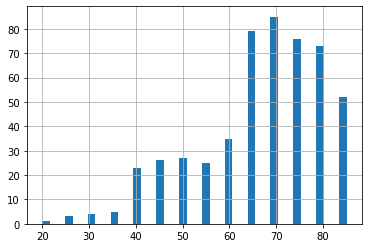

In [6]:
df_data_age = df_data[df_data['dx'] == 'bcc']
df_data_age['age'].hist(bins=40)

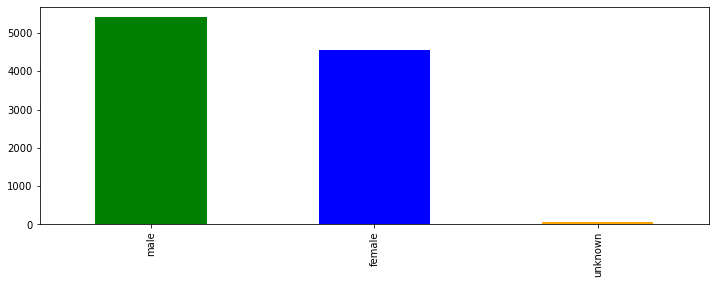

In [7]:
plt.figure(figsize=(12, 4))
df_data['sex'].value_counts().plot(kind='bar', color=['green', "blue", "orange"])

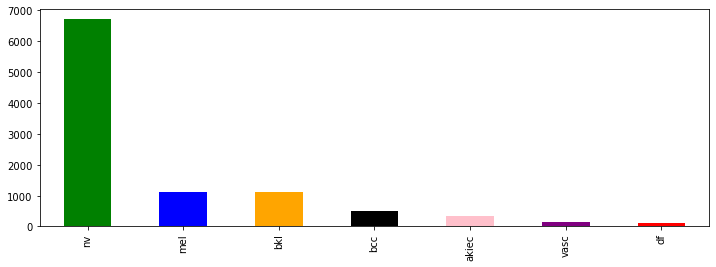

In [8]:
plt.figure(figsize=(12, 4))
df_data['dx'].value_counts().plot(kind='bar', color=["green", "blue", "orange", "black", "pink", "purple", "red"])

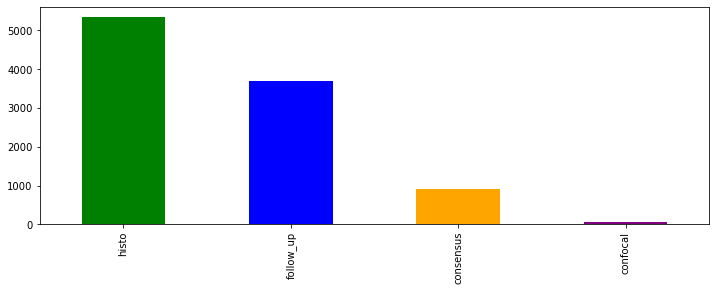

In [9]:
plt.figure(figsize=(12, 4))
df_data['dx_type'].value_counts().plot(kind='bar', color=["green", "blue", "orange", "purple"])

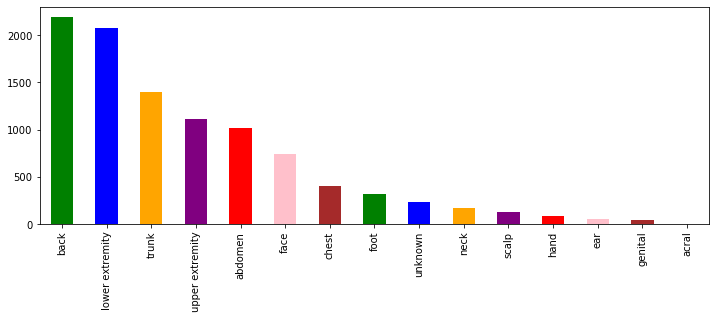

In [10]:
plt.figure(figsize=(12, 4))
df_data['localization'].value_counts().plot(kind='bar', color=["green", "blue", "orange", "purple", "red", "pink", "brown"])

# Checking Duplicate images

In [11]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1


# Seven types of symbols 

In [12]:
df_data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [13]:
# here we identify lesion_id's that have duplicate images and those that have only

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates


In [14]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [15]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 9)

# Seven types of symbols without duplicate images

In [16]:
df['dx'].value_counts()

nv       4415
bkl       440
mel       230
bcc       175
akiec     151
vasc       64
df         39
Name: dx, dtype: int64

In [17]:
# now we create a val set using df because we are sure that none of these images
y = df['dx']

_, df_val = train_test_split(df, test_size=0.545, random_state=101, stratify=y)

df_val.shape

(3006, 9)

# Create a train set 

In [18]:
# This set will be df_data excluding all rows that are in the val set
def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

7009
3006


In [19]:
df_train['dx'].value_counts()

nv       4298
mel       988
bkl       859
bcc       418
akiec     245
vasc      107
df         94
Name: dx, dtype: int64

# Create Validation and Test Set

In [20]:
# now we create a val set using df because we are sure that none of these images
y = df_val['dx']

df_val, df_test = train_test_split(df_val, test_size=0.666, random_state=101, stratify=y)

df_test.shape

(2002, 9)

In [21]:
df_val['dx'].value_counts()

nv       804
bkl       80
mel       42
bcc       32
akiec     27
vasc      12
df         7
Name: dx, dtype: int64

In [22]:
df_val.shape

(1004, 9)

In [23]:
df_test['dx'].value_counts()

nv       1603
bkl       160
mel        83
bcc        64
akiec      55
vasc       23
df         14
Name: dx, dtype: int64

# Transfer Images into the Folders

In [24]:
train_path = '.\\Documents\\Datasets\\base_dir_OverSample\\train_dir\\'
valid_path = '.\\Documents\\Datasets\\base_dir_OverSample\\val_dir\\'
test_path = '.\\Documents\\Datasets\\base_dir_OverSample\\test_dir\\'

In [25]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('.\\Documents\\Datasets\\HAM10000_images_part_1')
folder_2 = os.listdir('.\\Documents\\Datasets\\HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

# Transfer the training images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('.\\Documents\\Datasets\\HAM10000_images_part_1', fname)
        dst = os.path.join(train_path, label, fname)
        if not exists(dst):
          shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('.\\Documents\\Datasets\\HAM10000_images_part_2', fname)
        dst = os.path.join(train_path, label, fname)
        if not exists(dst):
          shutil.copyfile(src, dst)

# Transfer the validation images
for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('.\\Documents\\Datasets\\HAM10000_images_part_1', fname)
        dst = os.path.join(valid_path, label, fname)
        if not exists(dst):
          shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('.\\Documents\\Datasets\\HAM10000_images_part_2', fname)
        dst = os.path.join(valid_path, label, fname)
        if not exists(dst):
          shutil.copyfile(src, dst)

# Transfer the Test images
for image in test_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('.\\Documents\\Datasets\\HAM10000_images_part_1', fname)
        dst = os.path.join(test_path, label, fname)
        if not exists(dst):
          shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('.\\Documents\\Datasets\\HAM10000_images_part_2', fname)
        dst = os.path.join(test_path, label, fname)
        if not exists(dst):
          shutil.copyfile(src, dst)
        


# Oversampling ( Create augumented Data)

In [26]:
note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir(train_path + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join(train_path + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = train_path + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

In [27]:
# check how many train images we have in each folder


print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\nv'))) # 5
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\mel'))) # 4
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\bkl'))) # 2
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\bcc'))) # 1
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\akiec'))) # 0
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\vasc'))) # 6
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\train_dir\\df'))) # 3


4298
5978
5804
5634
5930
4330
5690


In [28]:
# check how many validation images we have in each folder


print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\nv'))) # 5
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\mel'))) # 4
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\bkl'))) # 2
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\bcc'))) # 1
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\akiec'))) # 0
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\vasc'))) # 6
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\val_dir\\df'))) # 3

804
42
80
32
27
12
7


In [29]:
# check how many test images we have in each folder

print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\nv'))) # 5
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\mel'))) # 4
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\bkl'))) # 2
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\bcc'))) # 1
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\akiec'))) # 0
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\vasc'))) # 6
print(len(os.listdir('.\\Documents\\Datasets\\base_dir\\test_dir\\df'))) # 3

1603
83
160
64
55
23
14


# Set Up the Generators

In [49]:
num_train_samples = 37664
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32
image_size = 64

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [50]:
print(len(df_val))
print(len(df_test))

1004
2002


# Augmented Data

In [51]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last')

In [52]:
train_batches = augmented_data.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = augmented_data.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = augmented_data.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37664 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [53]:
train_labels = train_batches.classes
valid_labels = valid_batches.classes
test_labels = test_batches.classes

# Create a CNN Model

In [54]:
inputs=Input((image_size, image_size, 3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation="softmax")(x)
    
model1 = Model(inputs, outputs)
model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 128)       0   

# Create a pre-traing transfer learning model vgg16

In [55]:
basemodel = VGG16(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()
    
for layer in basemodel.layers:
    layer.trainable = False
     
inputs = basemodel.input   
x = basemodel.output
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation='softmax')(x)
model2 = Model(inputs, outputs)
model2.summary()
    

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

# Create a pre-traing transfer learning model MobileNetV2

In [125]:
basemodel = MobileNetV2(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()

inputs = basemodel.input;
x = basemodel.layers[-6].output

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation='softmax')(x)

model3 = Model(inputs, outputs)
model3.summary()

for layer in basemodel.layers[:-25]:
    layer.trainable = False

C:\Users\HP\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_17[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_17[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
___________________________________________________________________________________________

# Create a pre-traing transfer learning model ResNet152V2

In [102]:
basemodel = ResNet152V2(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()

for layer in basemodel.layers:
    layer.trainable = False

inputs = basemodel.input;
x = basemodel.output

# x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
# x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation='softmax')(x)

model4 = Model(inputs, outputs)
model4.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

# Class Weights

In [42]:
class_weights = None

# Train AM-12 Model

In [58]:
# Train model
model1.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history1 = model1.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1177.0 steps, validate for 32.0 steps
Epoch 1/10
1177/1177 [==============================] - 1062s 902ms/step - loss: 1.6323 - accuracy: 0.3496 - mse: 0.1050 - val_loss: 0.9643 - val_accuracy: 0.7341 - val_mse: 0.0634
Epoch 2/10
1177/1177 [==============================] - 1043s 886ms/step - loss: 1.3595 - accuracy: 0.4419 - mse: 0.0941 - val_loss: 0.6637 - val_accuracy: 0.7888 - val_mse: 0.0425
Epoch 3/10
1177/1177 [==============================] - 1065s 905ms/step - loss: 1.2899 - accuracy: 0.4784 - mse: 0.0901 - val_loss: 0.6295 - val_accuracy: 0.7789 - val_mse: 0.0423
Epoch 4/10
1177/1177 [==============================] - 926s 787ms/step - loss: 1.2236 - accuracy: 0.5159 - mse: 0.0859 - val_loss: 0.5776 - val_accuracy: 0.7779 - val_mse: 0.0403
Epoch 5/10
1177/1177 [==============================] - 701s 596ms/step - loss: 1.1512 - accuracy: 0.5473 - mse: 0.0817 - val_loss: 0.7554 - val_accuracy: 0.7430 - val_mse: 0.0522

In [59]:
test_loss, test_accuracy, test_mse = model1.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
2002/2002 [==============================] - 46s 23ms/step - loss: 0.5362 - accuracy: 0.8207 - mse: 0.0353

Test Set Accuracy:  82.06793069839478 % 
Test Set Loss: 0.5362354954198713 
Test Set MSE: 0.03526774


In [60]:
predictions1 = model1.predict(test_batches, steps=len(df_test), verbose=1)
predictions1.shape
pre_labels = np.argmax(predictions1, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 46s 23ms/step
              precision    recall  f1-score   support

           0       0.42      0.18      0.25        55
           1       0.80      0.25      0.38        64
           2       0.37      0.14      0.21       160
           3       0.08      0.50      0.14        14
           4       0.44      0.29      0.35        83
           5       0.90      0.96      0.93      1603
           6       0.64      0.91      0.75        23

    accuracy                           0.82      2002
   macro avg       0.52      0.46      0.43      2002
weighted avg       0.81      0.82      0.80      2002



# Train VGG16 Model

In [61]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.vgg16.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37664 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [63]:
# Train model
model2.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history2 = model2.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1177.0 steps, validate for 32.0 steps
Epoch 1/10
1177/1177 [==============================] - 650s 552ms/step - loss: 1.1996 - accuracy: 0.5312 - mse: 0.0837 - val_loss: 0.6232 - val_accuracy: 0.7759 - val_mse: 0.0429
Epoch 2/10
1177/1177 [==============================] - 635s 540ms/step - loss: 0.9299 - accuracy: 0.6435 - mse: 0.0675 - val_loss: 0.6076 - val_accuracy: 0.7968 - val_mse: 0.0412
Epoch 3/10
1177/1177 [==============================] - 585s 497ms/step - loss: 0.8232 - accuracy: 0.6842 - mse: 0.0605 - val_loss: 0.6218 - val_accuracy: 0.7809 - val_mse: 0.0425
Epoch 4/10
1177/1177 [==============================] - 533s 453ms/step - loss: 0.7598 - accuracy: 0.7132 - mse: 0.0558 - val_loss: 0.5562 - val_accuracy: 0.8197 - val_mse: 0.0373
Epoch 5/10
1177/1177 [==============================] - 497s 422ms/step - loss: 0.6999 - accuracy: 0.7345 - mse: 0.0518 - val_loss: 0.5403 - val_accuracy: 0.8108 - val_mse: 0.0369
Ep

In [64]:
test_loss, test_accuracy, test_mse = model2.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
2002/2002 [==============================] - 52s 26ms/step - loss: 0.5675 - accuracy: 0.8302 - mse: 0.03591s - l

Test Set Accuracy:  83.01698565483093 % 
Test Set Loss: 0.5674528226003859 
Test Set MSE: 0.035874914


In [65]:
predictions2 = model2.predict(test_batches, steps=len(df_test), verbose=1)
print(predictions2.shape)
pre_labels = np.argmax(predictions2, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 57s 28ms/step
(2002, 7)
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        55
           1       0.57      0.61      0.59        64
           2       0.42      0.36      0.39       160
           3       0.26      0.57      0.36        14
           4       0.31      0.45      0.37        83
           5       0.94      0.93      0.93      1603
           6       0.67      0.70      0.68        23

    accuracy                           0.83      2002
   macro avg       0.52      0.57      0.53      2002
weighted avg       0.84      0.83      0.83      2002



# Train MobileNetV2 Model

In [126]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37664 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [127]:
# Train model
model3.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history3 = model3.fit(train_batches, steps_per_epoch=train_steps, 
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1177.0 steps, validate for 32.0 steps
Epoch 1/10
1177/1177 [==============================] - 596s 506ms/step - loss: 1.2367 - accuracy: 0.5317 - mse: 0.0852 - val_loss: 2.7784 - val_accuracy: 0.3337 - val_mse: 0.1503
Epoch 2/10
1177/1177 [==============================] - 584s 496ms/step - loss: 0.9111 - accuracy: 0.6627 - mse: 0.0650 - val_loss: 2.1984 - val_accuracy: 0.1215 - val_mse: 0.1405
Epoch 3/10
1177/1177 [==============================] - 583s 495ms/step - loss: 0.7446 - accuracy: 0.7274 - mse: 0.0539 - val_loss: 2.3842 - val_accuracy: 0.2221 - val_mse: 0.1371
Epoch 4/10
1177/1177 [==============================] - 590s 501ms/step - loss: 0.6160 - accuracy: 0.7740 - mse: 0.0450 - val_loss: 4.4866 - val_accuracy: 0.1733 - val_mse: 0.1741
Epoch 5/10
1177/1177 [==============================] - 582s 495ms/step - loss: 0.5016 - accuracy: 0.8175 - mse: 0.0369 - val_loss: 2.0685 - val_accuracy: 0.4373 - val_mse: 0.1145
Ep

In [128]:
test_loss, test_accuracy, test_mse = model3.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
2002/2002 [==============================] - 46s 23ms/step - loss: 3.2778 - accuracy: 0.5345 - mse: 0.1038

Test Set Accuracy:  53.44655513763428 % 
Test Set Loss: 3.277841788944862 
Test Set MSE: 0.103770785


In [129]:
predictions3 = model3.predict(test_batches, steps=len(df_test), verbose=1)
print(predictions3.shape)
pre_labels = np.argmax(predictions3, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 45s 22ms/step
(2002, 7)
              precision    recall  f1-score   support

           0       0.08      0.71      0.15        55
           1       0.12      0.17      0.14        64
           2       0.20      0.19      0.19       160
           3       0.01      0.07      0.02        14
           4       0.08      0.12      0.09        83
           5       0.92      0.61      0.73      1603
           6       0.00      0.00      0.00        23

    accuracy                           0.53      2002
   macro avg       0.20      0.27      0.19      2002
weighted avg       0.76      0.53      0.62      2002



# Train ResNet152V2 Model

In [109]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.resnet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37664 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [110]:
# Train model
model4.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history4 = model4.fit(train_batches, steps_per_epoch=train_steps, 
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1177.0 steps, validate for 32.0 steps
Epoch 1/10
1177/1177 [==============================] - 915s 777ms/step - loss: 1.4528 - accuracy: 0.4421 - mse: 0.0980 - val_loss: 1.7932 - val_accuracy: 0.3416 - val_mse: 0.1140
Epoch 2/10
1177/1177 [==============================] - 917s 779ms/step - loss: 1.1040 - accuracy: 0.5750 - mse: 0.0784 - val_loss: 1.9401 - val_accuracy: 0.3556 - val_mse: 0.1127
Epoch 3/10
1177/1177 [==============================] - 922s 783ms/step - loss: 0.8788 - accuracy: 0.6638 - mse: 0.0641 - val_loss: 1.8604 - val_accuracy: 0.4024 - val_mse: 0.1123
Epoch 4/10
1177/1177 [==============================] - 926s 787ms/step - loss: 0.6917 - accuracy: 0.7417 - mse: 0.0510 - val_loss: 2.1405 - val_accuracy: 0.3984 - val_mse: 0.1168
Epoch 5/10
1177/1177 [==============================] - 922s 783ms/step - loss: 0.5415 - accuracy: 0.7984 - mse: 0.0403 - val_loss: 2.6798 - val_accuracy: 0.3625 - val_mse: 0.1289
Ep

In [111]:
test_loss, test_accuracy, test_mse = model4.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
2002/2002 [==============================] - 150s 75ms/step - loss: 3.1219 - accuracy: 0.4550 - mse: 0.1225

Test Set Accuracy:  45.50449550151825 % 
Test Set Loss: 3.1218580624741463 
Test Set MSE: 0.12250795


In [112]:
predictions4 = model4.predict(test_batches, steps=len(df_test), verbose=1)
predictions4.shape

2002/2002 [==============================] - 160s 80ms/step


(2002, 7)

In [113]:
pre_labels = np.argmax(predictions4, axis = 1) 
print(classification_report(test_labels, pre_labels))

              precision    recall  f1-score   support

           0       0.12      0.15      0.13        55
           1       0.12      0.20      0.15        64
           2       0.17      0.17      0.17       160
           3       0.03      0.57      0.06        14
           4       0.06      0.24      0.09        83
           5       0.90      0.51      0.65      1603
           6       0.09      0.61      0.16        23

    accuracy                           0.46      2002
   macro avg       0.21      0.35      0.20      2002
weighted avg       0.75      0.46      0.55      2002



# Model Name

In [130]:
model1_name = "AM-12"
model2_name = "VGG16"
model3_name = "MobileNetV2"
model4_name = "ResNet152V2"

# Create Confusion Matrix

In [131]:
def create_confusion_matrix(test_labels, predictions, cm_plot_labels, name):
    
    #Compute the confusion matrix
    cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

    #Plot the confusion matrix
    plot_confusion_matrix(cm, cm_plot_labels, name) 

# Plot the confusion matrix for true vs predicted labels

In [132]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt

    if not exists('PhotosOver'):
        os.mkdir('PhotosOver')
    
    fig.savefig('.//PhotosOver//' + name + '_confusion_matrix.png', dpi=300)

# Testing Set Confusion Matrix for True vs Predicted Labels

In [133]:
print(test_labels)
print(test_batches.class_indices)

[0 0 0 ... 6 6 6]
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


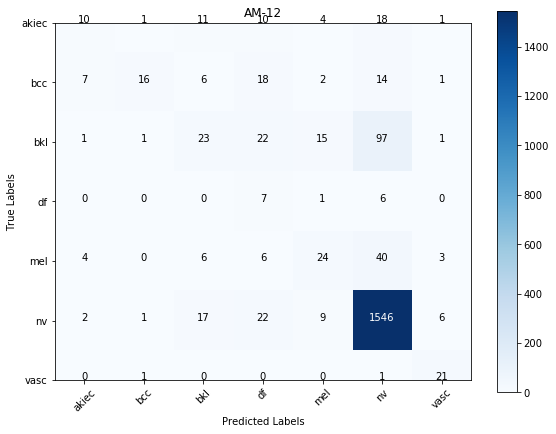

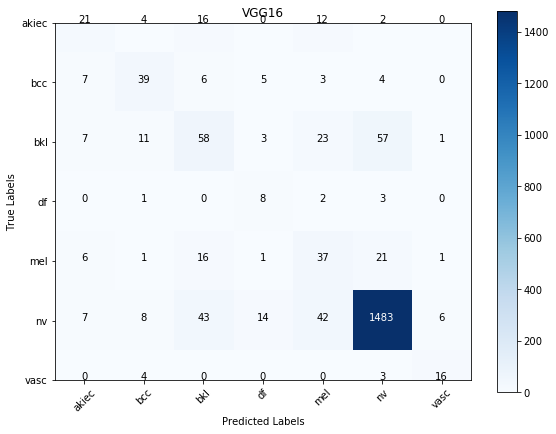

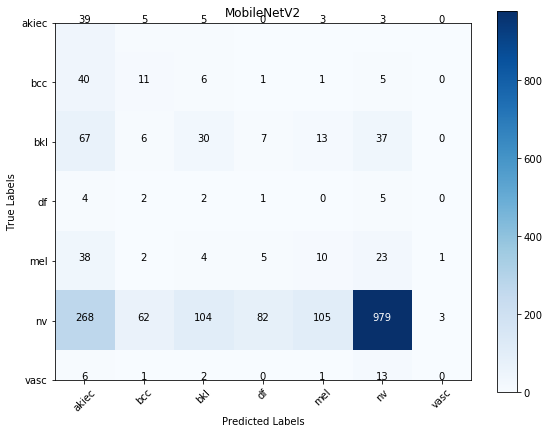

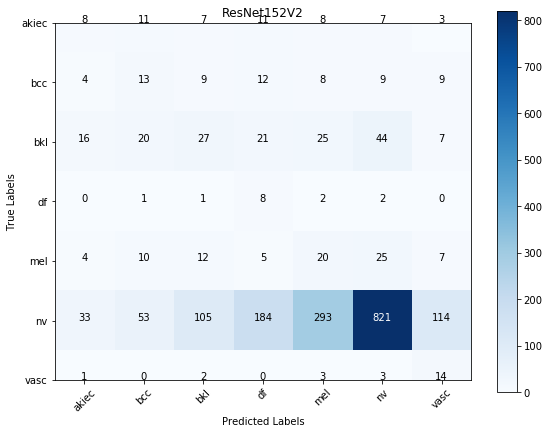

In [134]:
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
create_confusion_matrix(test_labels, predictions1, cm_plot_labels, model1_name)
create_confusion_matrix(test_labels, predictions2, cm_plot_labels, model2_name)
create_confusion_matrix(test_labels, predictions3, cm_plot_labels, model3_name)
create_confusion_matrix(test_labels, predictions4, cm_plot_labels, model4_name)

# Plot model accuracy + loss

In [135]:
def plot_model_history(model_history, name):
    
    fig = plt.figure(figsize=(15,10))

    #Summarize history for accuracy
    ax1 = plt.subplot(1,2,1) 
    ax1.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    ax1.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    ax1.legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    ax2 = plt.subplot(1,2,2) 
    ax2.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    ax2.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    ax2.legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('.//PhotosOver//' + name + '_model_history.png', dpi=300)

# Summarize Models Accuracy and Loss against Epochs

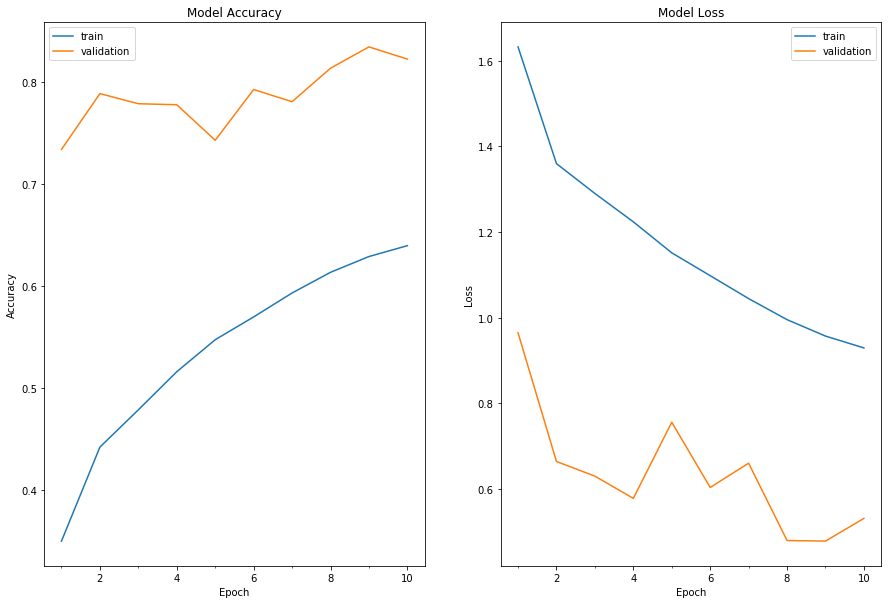

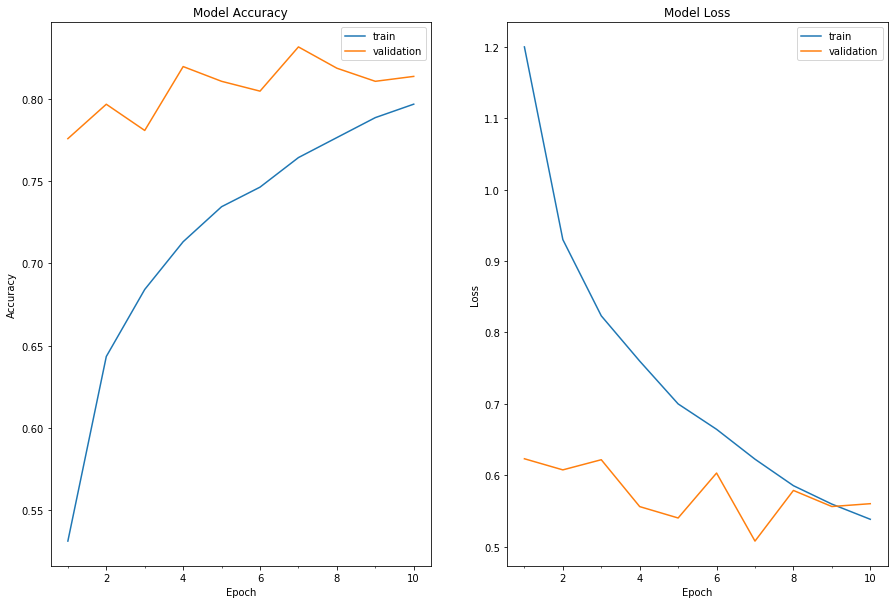

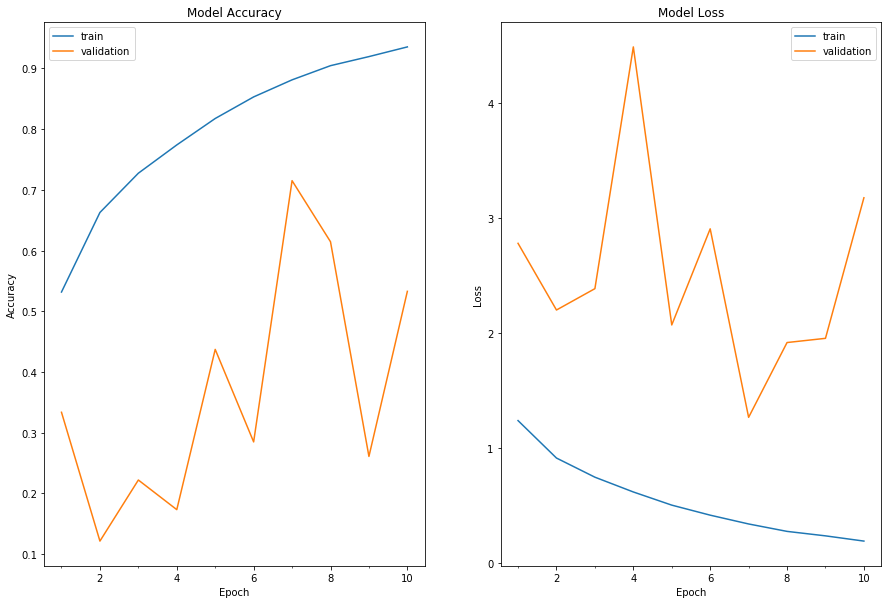

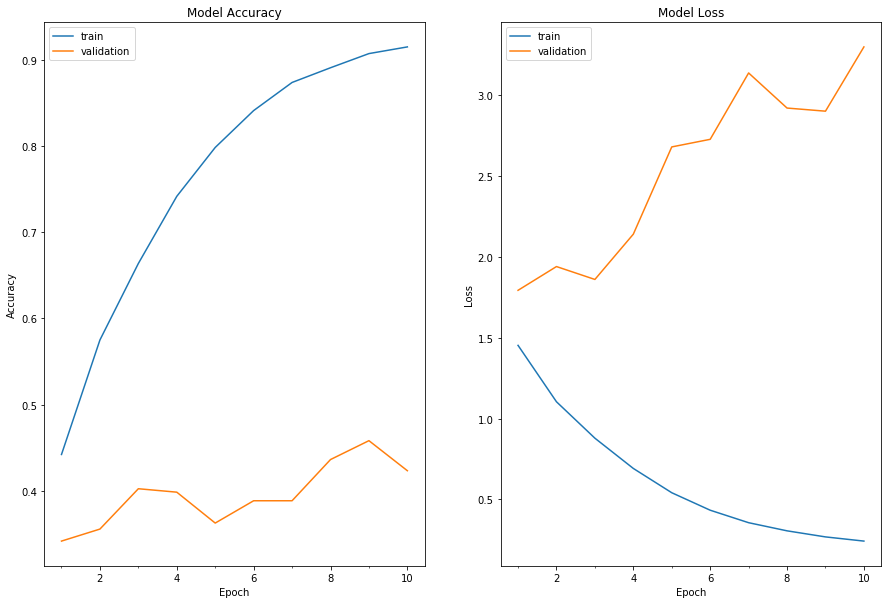

In [136]:
plot_model_history(history1, model1_name)
plot_model_history(history2, model2_name)
plot_model_history(history3, model3_name)
plot_model_history(history4, model4_name)